# Mass-Observable Relation Fit

Here we fit the mu-m200 mass observable relation. We disscuss the evolution of the slope.

## Packages

In [31]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 16})

import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")

import numpy as np
from scipy.interpolate import interp1d
import scipy

import pandas as pd

In [32]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

## Load Data

In [33]:
root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
cfg  = root+'config_buzzard_v2.yaml'

copa = copacabana(cfg,dataset='buzzard_v2')

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00035.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00038.hdf5
/data/des61.a/data/johnny

In [34]:
run_name = u'gauss003_r200_02Lstar_nfw'
cat = copa.load_copa_out('cluster',run_name)

mask = (cat['redshift']<0.6)&(cat['MU']>10.)&(cat['Ngals_true']>1.)

print('masked fraction: %.2f'%(1.*np.count_nonzero(mask)/len(cat)))
cat  = cat[mask] 

masked fraction: 0.74


In [35]:
N = len(cat)
print('sample size: %i'%N)

sample size: 1940


### Set Variables

In [36]:
sns.set_context('talk')

In [37]:
def get_mustar_log(x):
    x = np.where(x<1.,1.,x)
    return x*1e10

In [38]:
zcls = cat['redshift']
m200 = cat['M200_true']

mu    = get_mustar_log(cat['MU'])
muerr = get_mustar_log(cat['MU_ERR_JK'])

mut   = get_mustar_log(cat['MU_TRUE'])
muterr= get_mustar_log(cat['MU_TRUE_ERR_JK'])

ng    = cat['Ngals_flat']
ngt   = cat['Ngals_true']

In [88]:
x = m200
y1= mu
y2= mut
y3= ngt

y1err = muerr
y2err = muterr

### mu-star distribution

In [40]:
ylabel = r'$ \mu_{\star} $'
xlabel = r'$ M_{200} $'

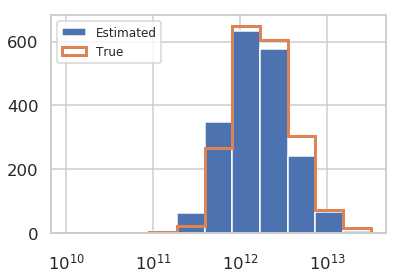

In [41]:
mulogbins = np.logspace(10,13.5,12)
a = plt.hist(mu,range=(10**10,10**13.5),bins=mulogbins,label='Estimated')
_ = plt.hist(mut,range=(10**10,10**13.5),
             bins=mulogbins,histtype='step',lw=3,label='True')

plt.xscale('log')
plt.legend(fontsize=12)

(31622776601683.793, 1584893192461111.0)

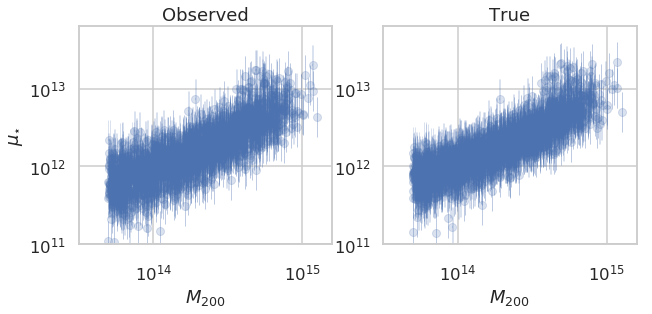

In [42]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)

ax.loglog()
# ax.scatter(x, y1,alpha=0.5)
ax.errorbar(x, y1, xerr=y1err, ls=' ',fmt='o', markersize=8, capsize=20, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Observed')
ax.set_xlim(10**13.5,10**15.2)
ax.set_ylim(10**11.,10**13.8)

ax = fig.add_subplot(122)
ax.loglog()
# ax.scatter(x, y2,alpha=0.5)
ax.errorbar(x, y2, xerr=y2err, ls=' ',fmt='o', markersize=8, capsize=20, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_title('True')
# ax.set_ylabel(ylabel)

ax.set_ylim(10**11.,10**13.8)
ax.set_xlim(10**13.5,10**15.2)


(array([  5.,  13., 124., 347., 478., 432., 328., 133.,  56.,  24.]),
 array([25.6540139 , 26.15990869, 26.66580347, 27.17169825, 27.67759303,
        28.18348782, 28.6893826 , 29.19527738, 29.70117216, 30.20706695,
        30.71296173]),
 <a list of 10 Patch objects>)

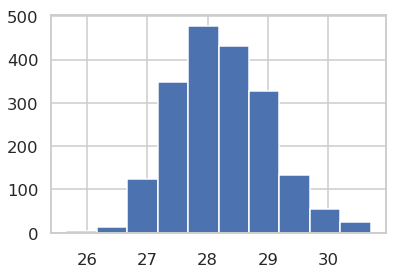

In [43]:
plt.hist(np.log(y2))

In [14]:
np.mean(np.log(y2err))

27.03460120522034

## Fit Linear Relation

### Linmix 

A Bayesian approach to linear regression with errors in both X and Y.

In [15]:
from kllr import *
import linmix

In [18]:
help(linmix.LinMix)

Help on class LinMix in module linmix.linmix:

class LinMix(__builtin__.object)
 |  A class to perform linear regression of `y` on `x` when there are measurement errors in
 |  both variables.  The regression assumes:
 |  
 |  eta = alpha + beta * xi + epsilon
 |  
 |  x = xi + xerr
 |  
 |  y = eta + yerr
 |  
 |  Here, `alpha` and `beta` are the regression coefficients, `epsilon` is the intrinsic random
 |  scatter about the regression, `xerr` is the measurement error in `x`, and `yerr` is the
 |  measurement error in `y`.  `epsilon` is assumed to be normally-distributed with mean zero and
 |  variance `sigsqr`.  `xerr` and `yerr` are assumed to be normally-distributed with means equal
 |  to zero, variances `xsig`^2 and `ysig`^2, respectively, and covariance `xycov`. The
 |  distribution of `xi` is modelled as a mixture of normals, with group proportions `pi`, means
 |  `mu`, and variances `tausqr`.
 |  
 |  Args:
 |      x(array_like): The observed independent variable.
 |      y(ar

In [19]:
np.std(np.log(x))

0.76718706

In [44]:
lm1 = linmix.LinMix(x, y1, ysig=y1err, K=3, nchains=12)
lm1.run_mcmc(silent=True)

In [45]:
lm2 = linmix.LinMix(x, y2, ysig=y2err, K=3, nchains=12)
lm2.run_mcmc(silent=True)

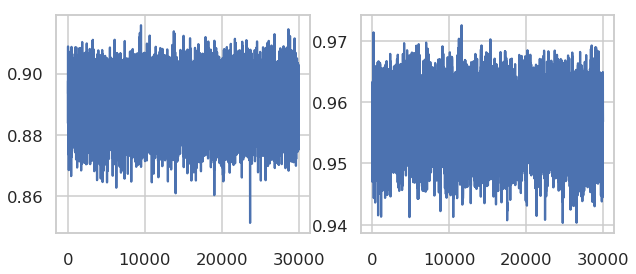

In [46]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
ax.plot(lm1.chain[:]['corr'])

ax = fig.add_subplot(122)
ax.plot(lm2.chain[:]['corr'])

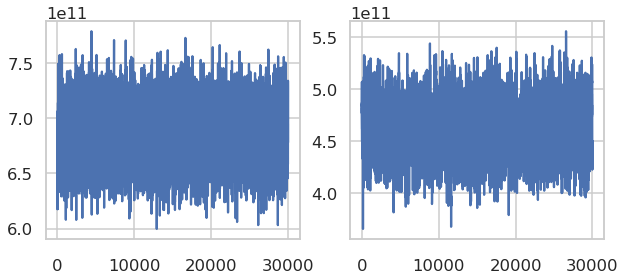

In [49]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
ax.plot(np.sqrt(lm1.chain[:]['sigsqr']))

ax = fig.add_subplot(122)
ax.plot(np.sqrt(lm2.chain[:]['sigsqr']))

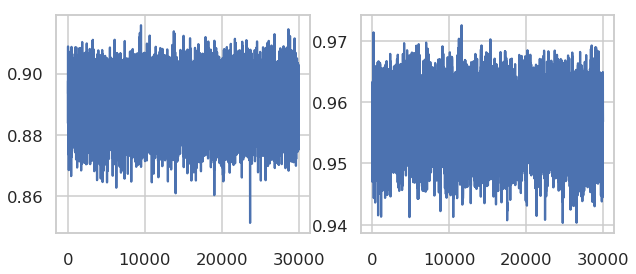

In [50]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
ax.plot(lm1.chain[:]['corr'])

ax = fig.add_subplot(122)
ax.plot(lm2.chain[:]['corr'])

In [51]:
lm2.chain[:].dtype

dtype([('alpha', '<f8'), ('beta', '<f8'), ('sigsqr', '<f8'), ('pi', '<f8', (3,)), ('mu', '<f8', (3,)), ('tausqr', '<f8', (3,)), ('mu0', '<f8'), ('usqr', '<f8'), ('wsqr', '<f8'), ('ximean', '<f8'), ('xisig', '<f8'), ('corr', '<f8')])

ValueError: x and y must be the same size

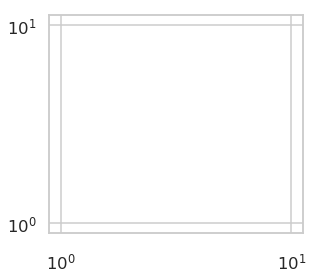

In [75]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
ax.loglog()
ax.scatter(x, y2, alpha=0.2)
# ax.errorbar(x, y2, xerr=y2err, ls=' ',fmt='o', markersize=8, capsize=20, alpha=0.2)
    
xs = np.linspace(10**13.6,10**15.2,100)
for i in range(0, len(lm1.chain), 50):
    #logxs = np.linspace(np.log(10**13.6),np.log(10**15.2),100)
    #logys = lm2a.chain[i]['alpha'] + logxs * lm2a.chain[i]['beta']
    #xs, ys = np.exp(logxs), np.exp(logys)
    ys = lm1.chain[i]['alpha'] + xs * lm1.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)

ax.set_ylim(10**11.,10**13.8)
ax.set_xlim(10**13.5,10**15.2)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('obs: %.2f, %.4f'%(np.log(np.mean(lm1.chain[:]['alpha'])),np.mean(lm1.chain[:]['corr'])))

ax = fig.add_subplot(122)
ax.loglog()
# ax.scatter(x, y2, alpha=0.2)
ax.errorbar(x, y2, xerr=y2err, ls=' ',fmt='o', markersize=8, capsize=20, alpha=0.2)
    
xs = np.linspace(10**13.6,10**15.2,100)
for i in range(0, len(lm2.chain), 50):
    #logxs = np.linspace(np.log(10**13.6),np.log(10**15.2),100)
    #logys = lm2b.chain[i]['alpha'] + logxs * lm2b.chain[i]['beta']
    #xs, ys = np.exp(logxs), np.exp(logys)
    ys = lm2.chain[i]['alpha'] + xs * lm2.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)

ax.set_ylim(10**11.,10**13.8)
ax.set_xlim(10**13.5,10**15.2)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('tru: %.2f, %.4f'%(np.mean(np.log(lm2.chain[:]['alpha'])),np.mean(lm2.chain[:]['corr'])))

fig.tight_layout()

In [89]:
def get_mean_error(yt,x,slope,intecept):
    dof = len(x)-1
    err = np.sum((yt-x*slope+intecept)**2,axis=0)/dof
    return np.sqrt(err)

In [97]:
slopes, intercept = lm1.chain[:]['beta'], lm1.chain[:]['alpha']

slopes   = np.tile(slopes,(len(x),1))
intercept= np.tile(intercept,(len(x),1))

xx = np.tile(np.array(x).copy(),(len(lm1.chain[:]),1)).T
yy1= np.tile(np.array(y1).copy(),(len(lm1.chain[:]),1)).T

dof = len(x)-1
err = np.sqrt(np.sum((np.log10(yy1)-np.log10(xx*slopes+intercept))**2,axis=0)/dof)

In [98]:
err

array([0.20302041, 0.20321125, 0.20328044, ..., 0.20301694, 0.20325678,
       0.20297026])

In [99]:
def get_stats(x):
    x16,x50,x84 = np.percentile(x,[16,50,84])
    s68 = (x84-x16)/2.
    return np.array([x50,x16,x84,s68])

def get_chain_results(self):
    metrics = ['alpha','beta','corr']
    
    out = dict().fromkeys(metrics)
    
    for mi in metrics:
        out[mi] = get_stats(self.chain[:][mi])
        
    return out

In [100]:
res = get_chain_results(lm1)

In [101]:
res['sig'] = get_stats(err)

In [102]:
res

{'alpha': array([2.15615913e+11, 1.85292776e+11, 2.45542010e+11, 3.01246169e+10]),
 'beta': array([0.00693486, 0.00682198, 0.00705135, 0.00011468]),
 'corr': array([0.8904541, 0.8836262, 0.8969908, 0.0066823]),
 'sig': array([0.20316743, 0.20300859, 0.20362759, 0.0003095 ])}

### KLLR

Kernel Localized Linear Regresion

In [65]:
from kllr import *

In [66]:
S = np.zeros((6, N))

S[0] = m200
S[1] = mu
S[2] = mut
S[3] = muerr
S[4] = muterr
S[5] = zcls

df = pd.DataFrame(S.T, columns = ['x', 'y1', 'y2','y1err','y2err','z'])

In [67]:
#df.to_csv('mor_mustar_g003_r200.csv')

In [80]:
# df = pd.read_csv('mor_mustar_g003_r200.csv')

for var in ['x','y1','y2']:
    df['log_%s'%var] = np.log10(df[var])

In [81]:
help(kllr_model.fit)

Help on method fit in module kllr.regression_model:

fit(self, X, y, y_err=None, xrange=None, bins=25, nBootstrap=100, fast_calc=False, verbose=False, compute_skewness=False, compute_kurtosis=False, kernel_type=None, kernel_width=None) unbound kllr.regression_model.kllr_model method
    This function computes the local regression parameters at the points within xrange.
    
    Parameters
    ----------
    x : numpy array
        Independent variable data vector. This version only support a one dimensional data vector.
    
    y : numpy array
        Dependent variable data vector. This version only support a one dimensional data vector.
    
    y_err : numpy array, optional
        Uncertainty on dependent variable, y.
        Must contain only non-zero positive values.
        Default is None.
    
    xrange : list, optional
        The first element is the min and the second element is the max,
        If None, it sets xrange to [min(x), max(x)]
    
    bins : int, optional
   

In [82]:
#! pip install --upgrade --user pandas

In [83]:
import pandas as pd
print(pd.__version__)

0.24.2


In [84]:
mybins = np.percentile(np.array(df['log_x']),np.linspace(0,100,16))

In [85]:
lm = kllr_model(kernel_type = 'gaussian', kernel_width = 0.45)

out = lm.fit(df['log_x'], df['log_y1'], y_err=None, bins=mybins)

xv, y_exp, intercept_exp, slope_exp, scatter_exp, _, _= out

In [130]:
def plot_add_linmix(xv,res,ax):
    ypred = np.log10(10**xv * res['beta'][0]+res['alpha'][0])

    p = ax[1].plot(xv,res['corr'][0]*np.ones_like(xv),'--')
    ax[1].fill_between(xv,res['corr'][1]*np.ones_like(xv),res['corr'][2]*np.ones_like(xv),alpha=0.3)

    color = p[0].get_color()
    ax[0].plot(xv, ypred, '--', lw=5, color=color)

    ax[2].plot(xv,res['sig'][0]*np.ones_like(xv),'--')
    ax[2].fill_between(xv,res['sig'][1]*np.ones_like(xv),res['sig'][2]*np.ones_like(xv),alpha=0.3)


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


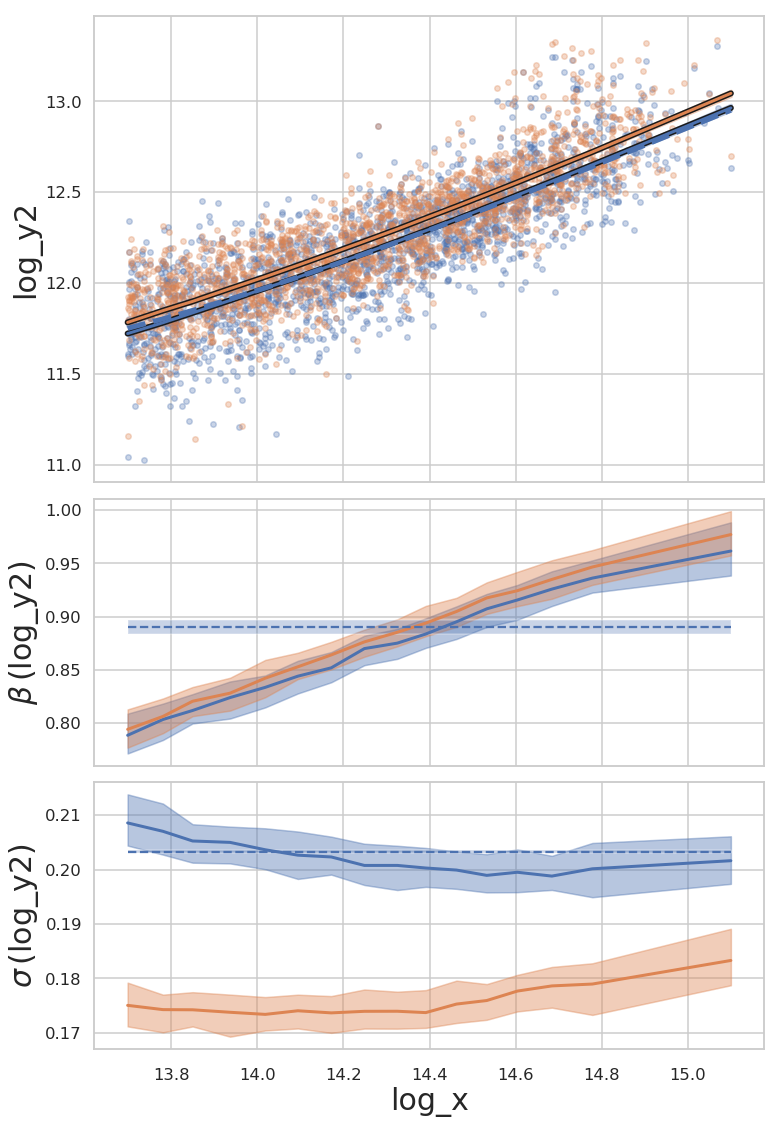

In [131]:
data, ax = Plot_Fit_Summary(df, 'log_x', 'log_y1', show_data=True, kernel_width = 0.46,bins=mybins)
data, ax = Plot_Fit_Summary(df, 'log_x', 'log_y2', show_data=True, kernel_width = 0.46,bins=mybins,ax=ax)

plot_add_linmix(data['x'],res,ax)

In [132]:
lm = kllr_model(kernel_type = 'gaussian', kernel_width = 0.45)

out = lm.fit(df['log_x'], df['log_y1'], y_err=np.log10(np.array(df['y1err'])), bins=mybins)

xv, y_exp, intercept_exp, slope_exp, scatter_exp, _, _= out

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()